# The Vehicle Routing Problem with Time Windows

This example illustrates a model for the vehicle routing problem with time windows (VRPTW).

In the VRPTW the objective is to minimize the total cost of routing vehicles from a central depot to a set of customers. Each customer must be visited exactly once within a specified time window to deliver their required demand, each customer has a service time it takes to unload the vehicle, and each vehicle has a maximum capacity of goods to deliver. If a vehicle arrives early it is allowed to wait for the customer's time window to start.

The network model can be formulated as

$$
\begin{aligned}
\min{ } & \sum_{(i,j) \in E} c_{ij} x_{ij} \\
\text{s.t. } & \sum_{(i,j) \in \delta^+(i)} x_{ij} = 1 & & i \in C \\
& x_{ij} = \sum_{p \in P} \Big ( \sum_{ s \in p: s = (i,j)} \mathbf{1} \Big ) \lambda_p & & (i,j) \in E \\
& 1 \leq \sum_{p \in P} \lambda_p \leq |C| \\
& \lambda_p \in \mathbb{B} && p \in P \\
& x_{i,j} \in \mathbb{B} && (i,j) \in E
\end{aligned}
$$

where $p \in P$ are elementary paths in a graph $G(V,E)$ subject to time and demand constraints modeled as disposable resources. Demand with vertex consumption $d_i$ and bounds $[0,Q]$ for all $i \in V$ and time with edge consumption $t_{ij}$ and vertex bounds $[a_i,b_i]$ for all $i \in V$. 

Written in $\lambda$ terms only, this is

$$
\begin{aligned}
\min{ } & \sum_{p \in P} \sum_{(i,j) \in E} c_{ij} \Big ( \sum_{ s \in p: s = (i,j)} \mathbf{1} \Big ) \lambda_p \\
\text{s.t. } &  \sum_{p \in P} \sum_{(i,j) \in \delta^+(i)} \Big ( \sum_{ s \in p: s = (i,j)} \mathbf{1} \Big ) \lambda_p = 1 & & i \in C \\
& 1 \leq \sum_{p \in P} \lambda_p \leq |C| \\
& \lambda_p \in \mathbb{B} && p \in P
\end{aligned}
$$

which may be more familiar.

The problem is modeled as

In [1]:
# data

from flowty import (
    Model,
    xsum,
    ParamKey,
    ParamInt,
    ParamValue,
    OptimizationStatus,
)
from flowty.datasets import vrp_rep

# fetch data
bunch = vrp_rep.fetch_vrp_rep(
    "solomon-1987-r1", instance="R101_025"
)
name, n, es, c, d, Q, t, a, b, x, y = bunch["instance"]

In [2]:
# VRPTW

m = Model()
# use the PathMip algorithm
m.setParam(
    ParamKey.Algorithm, ParamValue.AlgorithmPathMip
)
m.name = name

# the graph
g = m.addGraph(
    directed=True,
    obj=c,
    edges=es,
    source=0,
    sink=n - 1,
    L=1,
    U=n - 2,
    type="B",
)

# resource constriants
m.addResourceDisposable(
    graph=g,
    consumptionType="V",
    weight=d,
    boundsType="V",
    lb=0,
    ub=Q,
    obj=0,
    names="d",
)
m.addResourceDisposable(
    graph=g,
    consumptionType="E",
    weight=t,
    boundsType="V",
    lb=a,
    ub=b,
    obj=0,
    names="t",
)

m.addResourceElementary(graph=g, type="V", names="e")

# set partitioning constraints
for i in range(n)[1:-1]:
    m.addConstr(
        xsum(x * 1 for x in g.vars if i == x.source) == 1
    )

status = m.optimize()

print(f"ObjValue {m.objective}")

ObjValue 617.1


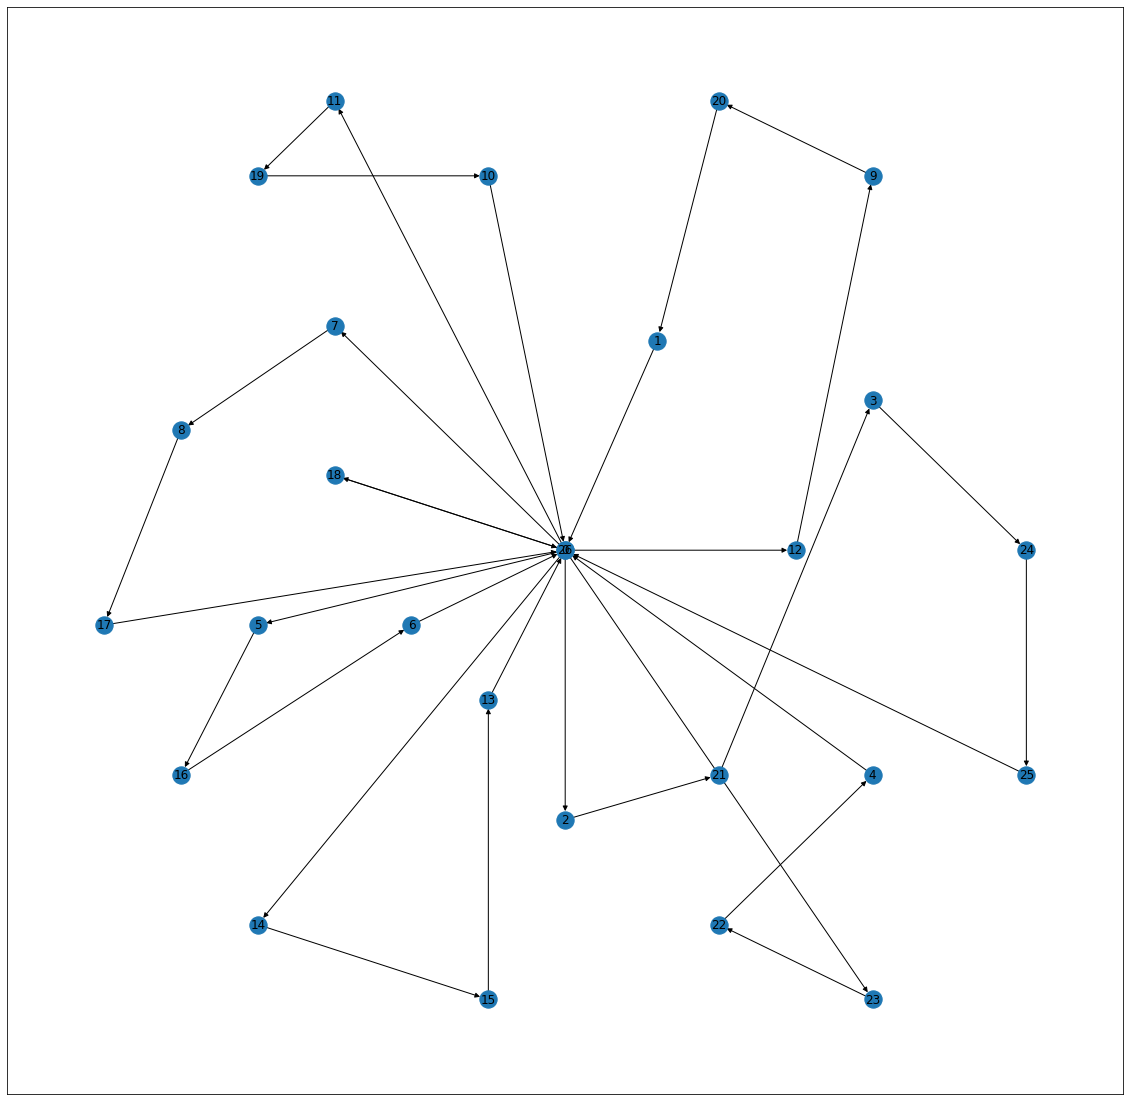

In [3]:
# display

# get the variables
xs = m.vars

# and print them
# for var in xs:
#    if var.x > 0:
#        print(f"{var.name} id:{var.idx} = {var.x}")

# display solution
import math
import networkx
import matplotlib
import matplotlib.pyplot as plt

if (
    status == OptimizationStatus.Optimal
    or status == OptimizationStatus.Feasible
):
    plt.figure(figsize=(20,20))
    edges = [
        var.edge
        for var in g.vars
        if not math.isclose(var.x, 0, abs_tol=0.001)
    ]
    g = networkx.DiGraph()
    g.add_nodes_from([i for i in range(n)])
    g.add_edges_from(edges)
    pos = {i: (x[i], y[i]) for i in range(n)}

    networkx.draw_networkx_nodes(g, pos, nodelist=g.nodes)
    labels = {i: i for i in g.nodes}
    networkx.draw_networkx_labels(g, pos, labels=labels)

    networkx.draw_networkx_edges(g, pos, nodelist=g.edges)

    plt.show()